## **Redes Neurais com Grafos** ##
### **Protótipo de classificação de vértices utilizando TensorFlow e Keras** ###
### Parte da postagem "Treinando Graph Neural Networks utilizando a Vertex AI" em www.medium.com/google-cloud-brasil

Primeiramente, valide que você tem todos os módulos necessários:

In [2]:
# # modulos necessários -- descomente essa
# # linha caso você não tenha estes módulos
# !pip install pandas numpy networkx matplotlib

Para que não haja erros cusados por diferenças de versões, é importante validar que você está executando o código com versões similares/compatíveis.

O meu ambiente de testes é baseado nas seguintes versões:

```
(base) jupyter@lab-grafos:~$ python3
Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> import tensorflow as tf
>>> import pandas as pd
>>> import numpy as np
>>> import networkx as nx
>>> import matplotlib as mpl
>>> print(tf.__version__)
2.10.1
>>> print(pd.__version__)
1.3.5
>>> print(np.__version__)
1.21.6
>>> print(nx.__version__)
2.6.3
>>> print(mpl.__version__)
3.5.3
```

## **1. Importando os módulos necessários** ##

Os módulos que utilizaremos neste notebook são os abaixo:

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Lambda
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## **2. Importando o dataset a ser utilizado** ##

Para este protótipo, iremos utilizar o [Cora dataset](https://www.openicpsr.org/openicpsr/project/100859/version/V1/view;jsessionid=EE14CC3F106F34B83472AD2C4E34459F) - que consiste em informações bibliográficas de artigos científicos relacionados à machine learning e categorizados em sete possíveis classes (Case_Based, Genetic_Algorithms, Neural_Networks, Probabilistic_Methods, Reinforcement_Learning, Rule_Learning e Theory).

Cada item no dataset possui uma estrutura específica:

- O arquivo `cora.cites` inclui informações sobre citações, em duas colunas: a coluna de "citado" (`cited_paper_id`) e de "citante" (`citing_paper_id`)
- O arquivo `core.contents` contém informações dos artigos distribuídos em 1435 colunas - incluindo `paper_id`, `subject` e 1433 features binárias (um word vector de tamanho 1433) 

Primeiro vamos fazer o download do dataset:

In [4]:
zip_file = keras.utils.get_file(
    fname='cora.tgz',
    origin='https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz',
    extract=True)

data_dir = os.path.join(os.path.dirname(zip_file), 'cora')

Primeiro vamos importar as informações de citações:

In [5]:
citations = pd.read_csv(
    os.path.join(data_dir, 'cora.cites'),
    sep='\t',
    header=None,
    names=['target', 'source'],
)
print('shape da estrutura de citações:', citations.shape)

shape da estrutura de citações: (5429, 2)


Podemos visualizar um pouco do conteúdo deste dataframe de citações:

In [6]:
citations.sample(frac=1).head()

,target,source
3934,101143,596075
4626,232605,25413
925,3236,601561
1381,6385,892139
622,2654,1152075


Agora vamos importar as informações dos artigos:

In [7]:
column_names = ['paper_id'] + [f'term_{idx}' for idx in range(1433)] + ['subject']
papers = pd.read_csv(
    os.path.join(data_dir, 'cora.content'), sep='\t', header=None, names=column_names,
)
print('shape das informações dos papers:', papers.shape)

shape das informações dos papers: (2708, 1435)


Vamos visualizar, também, um exemplo do dataframe de papers e a distribuição de papers por assunto (ou classes):

In [8]:
print(papers.sample(1).T)
print(papers.subject.value_counts())

                             2118
paper_id                   195361
term_0                          0
term_1                          0
term_2                          0
term_3                          0
...                           ...
term_1429                       0
term_1430                       0
term_1431                       0
term_1432                       0
subject    Reinforcement_Learning

[1435 rows x 1 columns]
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


Para normalizar a visualização, vamos corrigir os `paper_id` e `citation_id` iniciando em `0` e sequenciá-los:

In [9]:
class_values = sorted(papers['subject'].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers['paper_id'].unique()))}

papers['paper_id'] = papers['paper_id'].apply(lambda name: paper_idx[name])
citations['source'] = citations['source'].apply(lambda name: paper_idx[name])
citations['target'] = citations['target'].apply(lambda name: paper_idx[name])
papers['subject'] = papers['subject'].apply(lambda value: class_idx[value])

Com os nossos dados prontos, podemos usar o `NetworkX` e visualizar os relacionamentos de papers e citações plotando o grafo gerado:

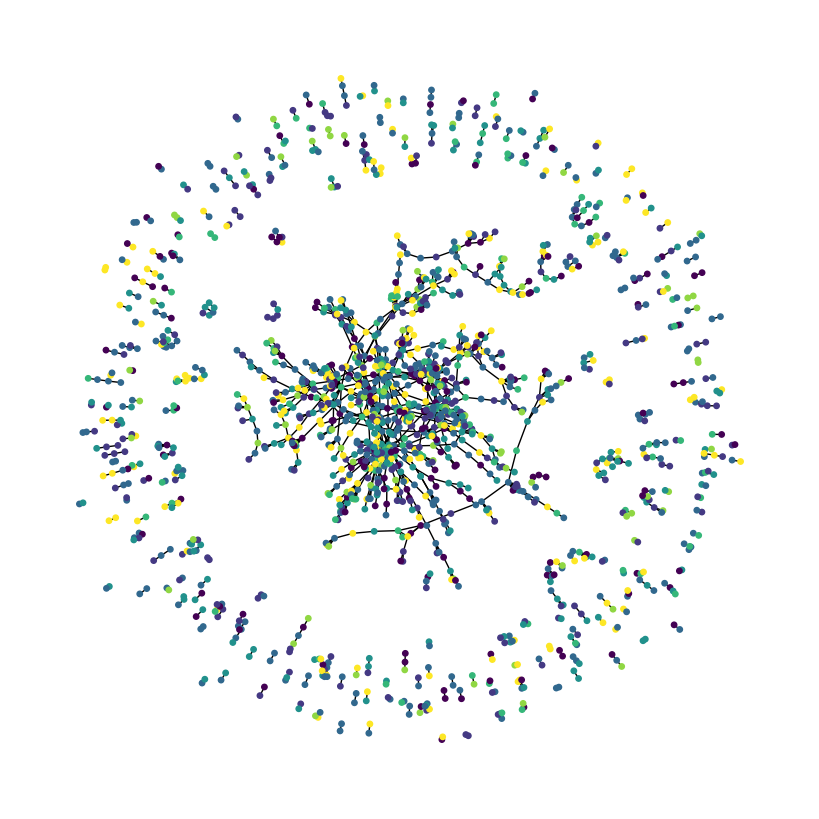

In [10]:
plt.figure(figsize=(8, 8))
colors = papers['subject'].tolist() # aqui definimos a quantidade de "cores" do grafo, baseado nos tipos de papers
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500)) # aqui criamos um grafo de exemplo, com uma amostra de 1500 citações
subjects = list(papers[papers['paper_id'].isin(list(cora_graph.nodes))]['subject'])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

### **3. Preparando o dataset para treinamento**

Como fazemos em qualquer cenário de machine learning, agora vamos preparar o dataset para ser utilizado no treinamento e teste do nosso modelo. Para isso, vamos dividir o nosso dataset em dois - `train_data` e `test_data`, sendo que usaremos cerca de 75% dos dados para treinamento e cerca de 25% dos dados para testes.

Preparar e carregar os dados, representados em forma de grafos, em modelos de machine learning para treinamento é um dos maiores desafios quando começamos a desenvolver soluções de *graph neural networks* (GNN). Há diversas formas, diversas abordagens e diversas bibliotecas para realizar essa atividade - Aqui, iremos realizar de uma forma bem simples, uma vez que o dataset sendo utilizado consiste de um único grafo e cabe inteiramente na memória.

In [11]:
train_data, test_data = [], []

# realiza o split dos dados em treinamento e testes
for _, group_data in papers.groupby('subject'):
    random_selection = np.random.rand(len(group_data.index)) <= 0.75
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print('shape do dataset treinamento:', train_data.shape)
print('shape do dataset teste:', test_data.shape)
print()

# informações sobre as features dos dataset
feature_names = set(papers.columns) - {'paper_id', 'subject'}
num_features = len(feature_names)
num_classes = len(class_idx)

# converte os datasets em arrays numpy
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

# converte os arrays das classes target em arrays numpy
y_train = train_data['subject']
y_test = test_data['subject']

# define a matrix de adjacência de shape [2, num_edges]
edges = citations[['source', 'target']].to_numpy().T

# define um array de 1's como um array de pesos
edge_weights = tf.ones(shape=edges.shape[1])

# cria o array de features dos vértices de shape [num_nodes, num_features]
node_features = tf.cast(
    papers.sort_values('paper_id')[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# cria a tupla de informaçoes do grafo do dataset
graph_info = (node_features, edges, edge_weights)

print('shape das arestas:', edges.shape)
print('shape dos vértices:', node_features.shape)

shape do dataset treinamento: (1983, 1435)
shape do dataset teste: (725, 1435)

shape das arestas: (2, 5429)
shape dos vértices: (2708, 1433)


### **4. Preparando o modelo GNN para treinamento** ###

Agora vamos criar a nossa graph neural network (GNN) usando TensorFlow e Keras. Neste cenário simples, vamos construir uma GNN com camadas com convoluções (*Graph Convolutional Layers*), onde iremos escrever, manualmente (sem utilizar um módulo com camadas pré-definidas).

**Importante:** Vale ressaltar que existem diversos módulos, com APIs para GNN e baseadas em TensorFlow, já preparados para acelerar esse desenvolvimento - Como exemplo, [Spectral](https://graphneural.network/), [StellarGraph](https://stellargraph.readthedocs.io/en/stable/README.html) e [GraphNets](https://github.com/deepmind/graph_nets) (somente para citar alguns).

Primeiro vamos criar a nossa função que irá fazer montar o *feedforward* do nosso modelo:

In [12]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

Agora vamos criar a nossa camada chamada `GraphConvLayer`, que irá utilizar o mecanismo de `FFN` recém criado.

A técnica implementada aqui idéias de diferentes implementações, como de [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907), [GraphSage](https://arxiv.org/abs/1706.02216), [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826), [Simple Graph Networks](https://arxiv.org/abs/1902.07153) e [Gated Graph Sequence Neural Networks](https://arxiv.org/abs/1511.05493). Há ainda outras técnicas, não utilizadas aqui, como [Graph Attention Networks](https://arxiv.org/abs/1710.10903) e [Message Passing Networks](https://arxiv.org/abs/1704.01212), apenas para dar dois exemplos.

In [13]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type='mean',
        combination_type='concat',
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == 'gated':
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation='tanh',
                recurrent_activation='sigmoid',
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == 'sum':
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'mean':
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'max':
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f'Invalid aggregation type: {self.aggregation_type}.')

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == 'gru':
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == 'concat':
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == 'add':
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f'Invalid combination type: {self.combination_type}.')

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == 'gru':
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

Agora será criado o processo de classificação, em si. Utilizando os mecanismos que acabaram de ser criados. A abordagem de *GNN Classification* que usamos aqui se baseaia na idéia de [Design Space for Graph Neural Networks ](https://arxiv.org/abs/2011.08843), onde:

- Se aplica um pré-processamento, utilizando *FFN*, às *features* dos vértices para se gerar a representação inicial dos vértices
- Daí se aplica uma ou mais camadas de convolução de grafo às representações dos vértices, gerando-se *embeddings* dos vértices
- Então se realiza um pós-processamento nos *embeddings*, utilizando *FFN*, para gerar os *embeddings* finais
- Finalmente, envia-se os *embeddings* finais a uma camada *softmax* para que seja feita a predição da classe dos vértices

**Importante:** cada camada de convolução adicionada captura informações adicionais sobre a vizinhança dos vértices. É importante experimentar e encontrar um número razoável de camadas para cada cenário para evitar cenários chamados de *oversmoothing* - onde o modelo acaba generalizando demais e criando *embeddings* quase idênticos para todos os vértices.

In [14]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type='sum',
        combination_type='concat',
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
            
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name='preprocess')
        
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name='graph_conv1',
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name='graph_conv2',
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name='postprocess')
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name='logits')

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

Juntando todos as partes que acabamos de criar, agora o modelo será, de fato, criado:

In [15]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name='gnn_model')

print('shape da saída do modelo GNN:', gnn_model([1, 10, 100]))
print()

gnn_model.summary()

shape da saída do modelo GNN: tf.Tensor(
[[-0.12396697 -0.1540765  -0.09755507  0.18021494 -0.2343488   0.17016976
  -0.21603993]
 [-0.05525471 -0.02818799  0.01387269  0.03016728 -0.0835162   0.1919814
   0.01520932]
 [-0.05091406 -0.14090182  0.0086997   0.19387041 -0.09950817 -0.0392906
  -0.07677337]], shape=(3, 7), dtype=float32)

Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                 

### **5. Realizar o treinamento do modelo GNN** ###

Agora será realizado o treinamento do modelo de GNN que acabamos de definir. Primeiro serão criadas duas funções: a que realizará o treinamento (aqui chamada de `run_experiment`) e a que irá plotar os gráficos das informações de treinamento:

In [16]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_acc', patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(['train', 'validation'], loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(history.history['acc'])
    ax2.plot(history.history['val_acc'])
    ax2.legend(['train', 'validation'], loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    plt.show()

E, finalmente, será realizado o treinamento do modelo GNN:

In [17]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
7/7 [==============================] - 6s 235ms/step - loss: 2.1355 - acc: 0.1887 - val_loss: 1.8864 - val_acc: 0.3289
Epoch 2/300
7/7 [==============================] - 1s 102ms/step - loss: 1.9708 - acc: 0.2433 - val_loss: 1.8683 - val_acc: 0.3423
Epoch 3/300
7/7 [==============================] - 1s 103ms/step - loss: 1.9014 - acc: 0.2617 - val_loss: 1.8480 - val_acc: 0.3423
Epoch 4/300
7/7 [==============================] - 1s 99ms/step - loss: 1.8633 - acc: 0.2861 - val_loss: 1.8268 - val_acc: 0.3423
Epoch 5/300
7/7 [==============================] - 1s 99ms/step - loss: 1.8490 - acc: 0.2837 - val_loss: 1.8215 - val_acc: 0.3423
Epoch 6/300
7/7 [==============================] - 1s 98ms/step - loss: 1.8534 - acc: 0.2807 - val_loss: 1.8105 - val_acc: 0.3423
Epoch 7/300
7/7 [==============================] - 1s 99ms/step - loss: 1.8225 - acc: 0.2831 - val_loss: 1.8036 - val_acc: 0.3423
Epoch 8/300
7/7 [==============================] - 1s 101ms/step - loss: 1.8047 - acc: 

Com o fim do treinamento, vamos avaliar as curvas de aprendizado:

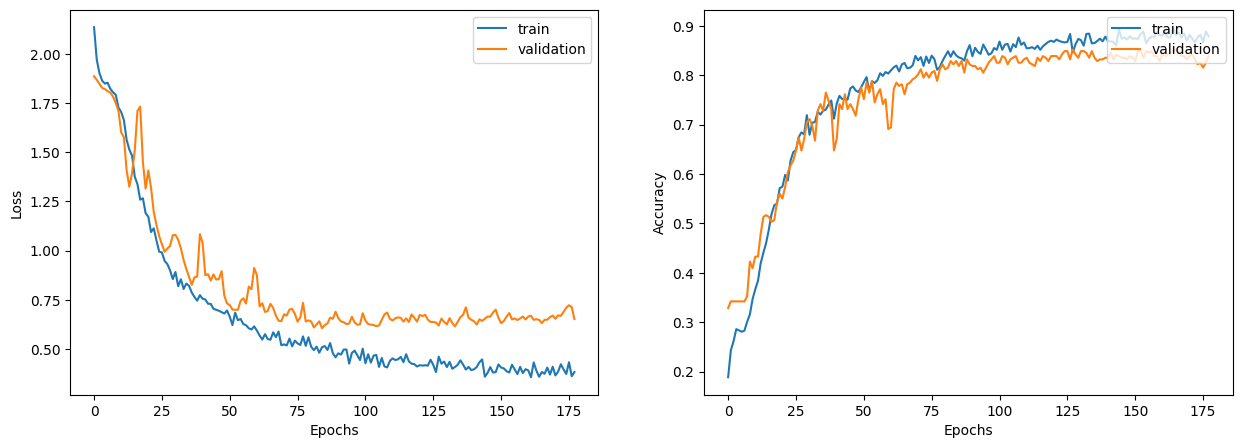

In [18]:
display_learning_curves(history)

E, finalmente, vamos avaliar a qualidade do novo modelo utilizando o dataset de testes:

In [19]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)

print(f'Test accuracy: {round(test_accuracy * 100, 2)}%')

Test accuracy: 84.83%


Para entender como a predição é feita, vamos montar uma função chamada `display_class_probabilities`, que irá "traduzir" as predições em relação aos valores reais do dataset de testes (vale ressaltar que, no final, está sendo impresso o valor real como comparativo com o que foi previsto pelo modelo):

In [20]:
def display_class_probabilities(probabilities, respostas):
    count = 0
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")
        print("Resposta correta:", class_values[respostas[count]])
        print()
        count += 1

Para entender como ficaria essa "tradução" da inferência, podemos pegar alguns exemplos do dataset de testes:

In [21]:
exemplos = test_data.paper_id.iloc[:3].to_numpy()
respostas = y_test[:3].tolist()

logits = gnn_model.predict(exemplos.tolist())
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities, respostas)

1/1 [==============================] - 0s 500ms/step
Instance 1:
- Case_Based: 0.08%
- Genetic_Algorithms: 0.09%
- Neural_Networks: 0.02%
- Probabilistic_Methods: 0.01%
- Reinforcement_Learning: 99.68%
- Rule_Learning: 0.0%
- Theory: 0.12%
Resposta correta: Reinforcement_Learning

Instance 2:
- Case_Based: 0.02%
- Genetic_Algorithms: 0.27%
- Neural_Networks: 98.97%
- Probabilistic_Methods: 0.25%
- Reinforcement_Learning: 0.04%
- Rule_Learning: 0.01%
- Theory: 0.43%
Resposta correta: Neural_Networks

Instance 3:
- Case_Based: 0.13%
- Genetic_Algorithms: 0.02%
- Neural_Networks: 0.69%
- Probabilistic_Methods: 0.24%
- Reinforcement_Learning: 1.01%
- Rule_Learning: 0.4%
- Theory: 97.51%
Resposta correta: Theory



Pronto!! Até aqui, realizamos várias etapas:

- definimos o desafio que queríamos resolver (classificar novos papers dada uma lista de possíveis tópicos)
- baixamos o nosso dataset e o preparamos para ser usado por uma GNN
- criarmos a nossa GNN, incluindo suas camadas e seu mecanismo de *feed forward* 
- treinamos o modelo de GNN que, mesmo super simples, conseguiu uma acurácia de ~85% no dataset de testes

Mas como podemos fazer esses mesmos procedimentos, porém utilizando a Google Cloud para realizar o treinamento, armazenamento e publicação do modelo em uma API?

Para isso, entra no cenário a [Vertex AI](https://cloud.google.com/vertex-ai?hl=pt-br).

### **6. Treinando a GNN utilizando a Vertex AI** ###

Para otimizar o processo de treinamento de nossa GNN, assim como para facilitar a produtização do modelo, vamos utilizar a [Vertex AI](https://cloud.google.com/vertex-ai/). A Vertex AI é a plataforma de desenvolvimento de machine learning dentro da Google Cloud. Com ela, você gerencia os seus datasets, realiza treinamentos (automatizados com AutoML ou customizados com seu código), realiza otimização de hiperparâmetros, estabelece rotinas de MLOps e implementa o seu modelo em APIs REST para ser utilizada pelos engenheiros de sua equipe.

Nesta seção você encontrará os passos para realizar o treinamento desde modelo GNN utilizando a Vertex AI, assim como as etapas para armazenar o modelo e implementá-lo em uma API REST.

Primeiro vamos fazer as atividades de preparação do processo:
- importação dos módulos necessários
- preparo do ambiente de treinamento (configuração de projeto, região da cloud e bucket)
- instanciamento do cliente da Vertex AI SDK
- preparação dos diretórios temporários locais que vão ser utilizados

#### **6.1. Importando os módulos necessários** ###

In [22]:
import os
import sys
import random
import string
import google.cloud.aiplatform as aiplatform

#### **6.2. Configuração de projeto, região e bucket para utilização no processo** ####

In [23]:
shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = shell_output[0]
print("Project ID:", PROJECT_ID)

Project ID: lucianomartins-demos-345000


In [24]:
REGION = "us-central1"

if REGION == "[your-region]":
    REGION = "us-central1"

In [25]:
from google.cloud import storage
from google.cloud.storage import Bucket

BUCKET_NAME = "vertex-gnn-lab"
BUCKET_URI = f"gs://{BUCKET_NAME}"

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

if not bucket.exists():
    bucket.create(location='us-central1')
    del bucket, client
    print('Criação de bucket realizada com sucesso. Bucket %s criado com sucesso' % BUCKET_NAME)
else:
    print('Criação de bucket cancelada. Bucket %s já existe' % BUCKET_NAME)

Criação de bucket realizada com sucesso. Bucket vertex-gnn-lab criado com sucesso


#### **6.3. Iniciando o cliente da Vertex AI** ####

In [26]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

#### **6.4. Preparando o ambiente de configuração do treinamento** ####

In [27]:
APPLICATION_DIR = "classificadorgnn"
TRAINER_DIR = f"{APPLICATION_DIR}/trainer"
PREDICTION_DIR = f"{APPLICATION_DIR}/prediction"
!mkdir -p $APPLICATION_DIR
!mkdir -p $TRAINER_DIR
!mkdir -p $PREDICTION_DIR

#### **6.5. Criando o código para treinamento** ####

In [28]:
%%writefile {TRAINER_DIR}/dataset.py

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')


def createDataset(link):
    # preparando o download do dataset
    zip_file = keras.utils.get_file(
    fname='cora.tgz',
    origin=link,
    extract=True)
    data_dir = os.path.join(os.path.dirname(zip_file), 'cora')
    logging.info('download do Cora dataset realizado com sucesso.')
    logging.info('\n')

    # criando a estrutura de citações
    citations = pd.read_csv(
    os.path.join(data_dir, 'cora.cites'),
    sep='\t',
    header=None,
    names=['target', 'source'])
    logging.info('shape da estrutura de citações:', citations.shape)
    logging.info('\n')

    # criando a estrutura de papers
    column_names = ['paper_id'] + [f'term_{idx}' for idx in range(1433)] + ['subject']
    papers = pd.read_csv(
    os.path.join(data_dir, 'cora.content'), sep='\t', header=None, names=column_names)
    logging.info('shape das informações dos papers:', papers.shape)
    logging.info('\n')

    # normalizando `paper_id` e `citation_id`
    class_values = sorted(papers['subject'].unique())
    class_idx = {name: id for id, name in enumerate(class_values)}
    paper_idx = {name: idx for idx, name in enumerate(sorted(papers['paper_id'].unique()))}
    papers['paper_id'] = papers['paper_id'].apply(lambda name: paper_idx[name])
    citations['source'] = citations['source'].apply(lambda name: paper_idx[name])
    citations['target'] = citations['target'].apply(lambda name: paper_idx[name])
    papers['subject'] = papers['subject'].apply(lambda value: class_idx[value])
    logging.info('estrutura do dataset criada com sucesso.')

    return(citations, papers, class_idx)


def preparaDataset(citations, papers, class_idx):
    train_data, test_data = [], []

    for _, group_data in papers.groupby('subject'):
        # Select around 50% of the dataset for training.
        random_selection = np.random.rand(len(group_data.index)) <= 0.75
        train_data.append(group_data[random_selection])
        test_data.append(group_data[~random_selection])

    train_data = pd.concat(train_data).sample(frac=1)
    test_data = pd.concat(test_data).sample(frac=1)

    logging.info('shape do dataset treinamento:', train_data.shape)
    logging.info('shape do dataset teste:', test_data.shape)
    logging.info('\n')

    # informações sobre as features dos dataset
    feature_names = set(papers.columns) - {'paper_id', 'subject'}
    num_features = len(feature_names)
    num_classes = len(class_idx)

    # converte os datasets em arrays numpy
    x_train = train_data[feature_names].to_numpy()
    x_test = test_data[feature_names].to_numpy()

    # converte os arrays das classes target em arrays numpy
    y_train = train_data['subject']
    y_test = test_data['subject']

    # definir a matrix de adjacência de shape [2, num_edges]
    edges = citations[['source', 'target']].to_numpy().T

    # definir um array de 1's como um array de pesos
    edge_weights = tf.ones(shape=edges.shape[1])

    # criar o array de features dos vértices de shape [num_nodes, num_features]
    node_features = tf.cast(
        papers.sort_values('paper_id')[feature_names].to_numpy(), dtype=tf.dtypes.float32
    )
    # criar a tupla de informaçoes do grafo do dataset
    graph_info = (node_features, edges, edge_weights)

    logging.info('shape das arestas:', edges.shape)
    logging.info('shape dos vértices:', node_features.shape)

    return(train_data, test_data, x_train, y_train, 
           x_test, y_test, num_classes, graph_info)

Overwriting classificadorgnn/trainer/dataset.py


In [29]:
%%writefile {TRAINER_DIR}/model.py

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore') 


# criando o mecanismo de feedforward da GNN
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type='mean',
        combination_type='concat',
        normalize=False,
        *args,
        **kwargs):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == 'gated':
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation='tanh',
                recurrent_activation='sigmoid',
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)


    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages


    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == 'sum':
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'mean':
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'max':
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f'Invalid aggregation type: {self.aggregation_type}.')

        return aggregated_message


    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == 'gru':
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == 'concat':
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == 'add':
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f'Invalid combination type: {self.combination_type}.')

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == 'gru':
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings


    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type='sum',
        combination_type='concat',
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name='preprocess')
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name='graph_conv1')
        
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name='graph_conv2')
        
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name='postprocess')
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name='logits')


    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

Overwriting classificadorgnn/trainer/model.py


In [30]:
%%writefile {TRAINER_DIR}/train.py

import pickle
from google.cloud import storage

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from trainer.dataset import *
from trainer.model import *

import warnings
warnings.filterwarnings('ignore') 

# baixando o dataset
link = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'
citations, papers, class_idx = createDataset(link)

# definindo os hiperparâmetros do modelo
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256
output_directory = os.environ['AIP_MODEL_DIR']

# preparando o dataset para uso na GNN
train_data, test_data, x_train, y_train, \
x_test, y_test, num_classes, graph_info = preparaDataset(citations, papers, class_idx)

# salvando os objetos no Cloud Storage
storage_client = storage.Client()
bucket_name = output_directory.split('/')[2]
bucket = storage_client.bucket(bucket_name)
# objetos relacionados ao dataset
savefile = pickle.dumps(graph_info)
blob = bucket.blob('train_assets/graph_info.pickle')
blob.upload_from_string(savefile)
    

def criaModelo(graph_info, num_classes, hidden_units, dropout_rate):
    # fazendo a definição do modelo
    gnn_model = GNNNodeClassifier(
        graph_info=graph_info,
        num_classes=num_classes,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        name='gnn_model')

    logging.info('shape da saída do modelo GNN:', gnn_model([1, 10, 100]))
    logging.info('\n')
    gnn_model.summary()
    logging.info('\n')

    return(gnn_model)

def treinaModelo(gnn_model, x_train, y_train):
    # compila o modelo gnn
    gnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
    )
    # cria um callback de early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_acc', patience=50, restore_best_weights=True
    )

    # transforma o dataset de treino em um array numpy
    x_train = train_data.paper_id.to_numpy()

    # faz o treinamento, de fato, do modelo
    history = gnn_model.fit(
            x=x_train,
            y=y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_split=0.15,
            callbacks=[early_stopping])
    logging.info('\n')

    return(gnn_model)


def avaliaModelo(gnn_model):
    x_test = test_data.paper_id.to_numpy()
    _, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
    logging.info('Iniciando a validação do modelo GNN')
    logging.info(f'Test accuracy: {round(test_accuracy * 100, 2)}%')
    logging.info('\n')

if __name__ == '__main__':
    
    logging.info('*'*50)
    logging.info('treinamento de um modelo de classificação de grafos')
    logging.info('utilizando o Cora dataset')
    logging.info('*'*50)
    logging.info('\n')

    model = criaModelo(graph_info, num_classes, hidden_units, dropout_rate)
    gnn_model = treinaModelo(model, x_train, y_train)
    avaliaModelo(gnn_model)
    gnn_model.save(output_directory)

    logging.info('*'*50)
    logging.info('treinamento finalizado')
    logging.info('*'*50)
    logging.info('\n')

Overwriting classificadorgnn/trainer/train.py


#### **6.6. Criando uma imagem customizada de container para treinamento** ####

In [31]:
%%writefile {APPLICATION_DIR}/Dockerfile

FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-10

WORKDIR /

# copia o código de treinamento para dentro da imagem
COPY trainer /trainer

# configura o ENTRYPOINT do container
ENTRYPOINT ["python", "-m", "trainer.train"]

Overwriting classificadorgnn/Dockerfile


In [32]:
REPO_NAME_TRAINING='classificador-gnn-repo'

## as duas linhas abaixo só precisam ser executadas uma vez para este cenário
!gcloud artifacts repositories create $REPO_NAME_TRAINING --repository-format=docker --location=$REGION --description="Repositorio de treinamento de GNN"
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet

Create request issued for: [classificador-gnn-repo]
Waiting for operation [projects/lucianomartins-demos-345000/locations/us-centra
l1/operations/9498b2c4-3341-42d8-87d1-c8723f4773da] to complete...done.        
Created repository [classificador-gnn-repo].

{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


In [33]:
IMAGE_URI = (f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME_TRAINING}/classificador-gnn:latest")
! cd $APPLICATION_DIR; docker build ./ -t $IMAGE_URI; docker push $IMAGE_URI

Sending build context to Docker daemon  39.42kB
Step 1/4 : FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-10
 ---> a4f0701935e1
Step 2/4 : WORKDIR /
 ---> Using cache
 ---> 722b728a1f1d
Step 3/4 : COPY trainer /trainer
 ---> Using cache
 ---> 72634722e200
Step 4/4 : ENTRYPOINT ["python", "-m", "trainer.train"]
 ---> Using cache
 ---> 757e1d7b0d24
Successfully built 757e1d7b0d24
Successfully tagged us-central1-docker.pkg.dev/lucianomartins-demos-345000/classificador-gnn-repo/classificador-gnn:latest
The push refers to repository [us-central1-docker.pkg.dev/lucianomartins-demos-345000/classificador-gnn-repo/classificador-gnn]

6d1e9126: Preparing 
74c9a41d: Preparing 
17004f9d: Preparing 
87d1f30a: Preparing 
07a0e80a: Preparing 
e7c39a5d: Preparing 
81da1d79: Preparing 
7fb519a7: Preparing 
b3c2c479: Preparing 
e7f8b264: Preparing 
cda284f7: Preparing 
b2ad3e2e: Preparing 
fcf3d1f5: Preparing 
5b0660d9: Preparing 
110192fa: Preparing 
ecbed63e: Preparing 
839a31a4: Preparing 
c92a3

#### **6.7. Criando o job de treinamento da Vertex AI** ####

In [34]:
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-8",
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME_TRAINING}/classificador-gnn:latest"
        },
    }
]

my_custom_job = aiplatform.CustomJob(
    display_name="classificador-gnn-job",
    worker_pool_specs=worker_pool_specs,
    staging_bucket=BUCKET_URI
)

model = my_custom_job.run(sync=True)

Creating CustomJob
CustomJob created. Resource name: projects/48397268769/locations/us-central1/customJobs/9184012131920510976
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/48397268769/locations/us-central1/customJobs/9184012131920510976')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/9184012131920510976?project=48397268769
CustomJob projects/48397268769/locations/us-central1/customJobs/9184012131920510976 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/48397268769/locations/us-central1/customJobs/9184012131920510976 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/48397268769/locations/us-central1/customJobs/9184012131920510976 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/48397268769/locations/us-central1/customJobs/9184012131920510976 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/48397268769/locations/us-central1/customJobs/918401213192051

#### **6.8. Fazendo o upload do modelo treinado para a Model Registry da Vertex AI** ####

Com o treinamento finalizado com sucesso, detalhes do processo de treinamento (incluindo logs gerados durante o treinamento) podem ser encontrados na console da Vertex AI, em [Treinamento > Custom Jobs](https://console.cloud.google.com/vertex-ai/training/custom-jobs).

Para seguir com o processo aqui, precisamos salvar o diretório do Cloud Storage onde o modelo foi salvo:

In [35]:
model_artifact = !gsutil ls -l $BUCKET_URI | grep aiplatform-custom-job | tail -n 1 | tr -d ' '
model_artifact[0]

'gs://vertex-gnn-lab/aiplatform-custom-job-2023-04-13-17:19:54.220/'

#### **6.9. Criando a imagem de container customizada para predições na Vertex AI** ####

Como temos um modelo customizado, com uma sequência específica de etapas de predição, precisamos criar uma imagem de container customizada para predições - o que a Vertex AI chama de CPR ou *custom prediction routines*. Maiores detalhes sobre este tópico podem ser encontradas na [documentação da Vertex AI](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines).

In [36]:
%%writefile {PREDICTION_DIR}/predictor.py

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.cloud import storage
from google.cloud.aiplatform.utils import prediction_utils
from google.cloud.aiplatform.prediction.predictor import Predictor

import warnings
warnings.filterwarnings('ignore')

# baixando os objetos no Cloud Storage
storage_client = storage.Client('lucianomartins-demos-345000') # ponha aqui o id do seu projeto
bucket = storage_client.get_bucket('vertex-gnn-lab') # ponha aqui o nome do seu bucket
blob = bucket.blob('train_assets/graph_info.pickle')
blob.download_to_filename('graph_info.pickle')

# definindo os hiperparâmetros do modelo
hidden_units = [32, 32]
dropout_rate = 0.5
num_classes = 7
localfile = open('graph_info.pickle', 'rb')
graph_info = pickle.load(localfile)


# criando o mecanismo de feedforward da GNN
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
    
    return keras.Sequential(fnn_layers, name=name)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        aggregation_type='mean',
        combination_type='concat',
        normalize=False,
        *args,
        **kwargs):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == 'gated':
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation='tanh',
                recurrent_activation='sigmoid',
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)


    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages


    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == 'sum':
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'mean':
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'max':
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f'Invalid aggregation type: {self.aggregation_type}.')

        return aggregated_message


    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == 'gru':
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == 'concat':
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == 'add':
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f'Invalid combination type: {self.combination_type}.')

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == 'gru':
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings


    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        num_classes=num_classes,
        hidden_units=hidden_units,
        graph_info=graph_info,
        aggregation_type='sum',
        combination_type='concat',
        dropout_rate=dropout_rate,
        normalize=True,
        *args,
        **kwargs):
        super().__init__(*args, **kwargs)
        
        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name='preprocess')
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name='graph_conv1')
        
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name='graph_conv2')
        
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name='postprocess')
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name='logits')


    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


class CprPredictor(Predictor):
    
    
    def __init__(self):
        return
    
    
    def load(self, artifacts_uri):
        """Loads the model artifacts."""
        prediction_utils.download_model_artifacts(artifacts_uri)
        self._model = tf.keras.models.load_model(filepath='.', 
                                                 custom_objects={
                                                     'GraphConvLayer': GraphConvLayer, 
                                                     'GNNNodeClassifier': GNNNodeClassifier,
                                                     'graph_info': graph_info
                                                 })


    def predict(self, instances):
        """Performs prediction."""
        instances = instances["instances"][0]
        logits = self._model.predict([instances])
        probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
        return([instances, probabilities.tolist()[0]])

    
    def postprocess(self, prediction_results):
        return {"predictions": prediction_results}

Overwriting classificadorgnn/prediction/predictor.py


Para que não haja problemas durante a execução, é importante definir o arquivo `requirements.txt` com a versão de TensorFlow que deve estar disponível no container de inferência (neste caso, a versão 2.10).

In [37]:
%%writefile {PREDICTION_DIR}/requirements.txt

tensorflow==2.10

Overwriting classificadorgnn/prediction/requirements.txt


Utilizando-se o método `LocalModel.build_cpr_model` de Custom Prediction Routines da SDK da Vertex AI, uma imagem de container customizada será criada localmente.

In [38]:
import os

from google.cloud.aiplatform.prediction import LocalModel
from classificadorgnn.prediction.predictor import CprPredictor

REPO_NAME_SERVING='predictor-gnn-repo'

local_model = LocalModel.build_cpr_model(
    src_dir=PREDICTION_DIR,
    output_image_uri=f'{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME_SERVING}/predictor-gnn:latest',
    predictor=CprPredictor,
    requirements_path=os.path.join(PREDICTION_DIR, 'requirements.txt'))

local_model.get_serving_container_spec()

image_uri: "us-central1-docker.pkg.dev/lucianomartins-demos-345000/predictor-gnn-repo/predictor-gnn:latest"
predict_route: "/predict"
health_route: "/health"

Antes de realizar o *push* da imagem de container para a Artifacts Registry na Google Cloud, é interessante validar que não há nenhum erro de execução ou de código dentro da imagem. Para isso, a SDK da Vertex AI permite uma validação local da imagem. Primeiro deve ser criado um arquivo *json* com um exemplo de inferência (neste caso, um identificador de vértice do grafo, parte do dataset de testes):

In [39]:
%%writefile input.json
{
    "instances": [
        [1097]
    ]
}

Overwriting input.json


Após isso, executa-se uma inferência utilizando o arquivo *json* criado.

In [40]:
with local_model.deploy_to_local_endpoint(
    artifact_uri=f"{model_artifact[0] + 'model'}",
) as local_endpoint:
    predict_response = local_endpoint.predict(
        request_file='input.json',
        headers={"Content-Type": "application/json"},
    )

    health_check_response = local_endpoint.run_health_check()

print(predict_response, predict_response.content)

<Response [200]> b'{"predictions": [[1097], [[0.00045717868488281965, 0.0006561254267580807, 0.9924376606941223, 0.0030325090046972036, 0.0018617843743413687, 4.6111141273286194e-05, 0.0015086645726114511]]]}'


A inferência funcionou com sucesso - então, podemos concluir que nossa imagem de container está operacional. Caso ocorra erros e uma etapa de troubleshooting seja necessária, pode-se checar os logs do container de inferência fazendo uma chamada a função `print_container_logs()`.

In [41]:
local_endpoint.print_container_logs(show_all=True)

Com a imagem de container validada, faz-se a criação do repositório de imagens de container, para a imagem de predição, dentro da Artifacts Registry:

In [42]:
## as duas linhas abaixo só precisam ser executadas uma vez para este cenário
!gcloud artifacts repositories create $REPO_NAME_SERVING --repository-format=docker --location=$REGION --description="Repositorio de predicao de GNN"
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet

Create request issued for: [predictor-gnn-repo]
Waiting for operation [projects/lucianomartins-demos-345000/locations/us-centra
l1/operations/23695847-dffb-47f5-9973-921e8dc8864d] to complete...done.        
Created repository [predictor-gnn-repo].

{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


E, finalmente, realiza-se o *push* da imagem no repositório:

In [43]:
local_model.push_image()

A próxima etapa é fazer o upload do modelo, que está salvo no Cloud Storage, para dentro da [Model Registry da Vertex AI](https://cloud.google.com/vertex-ai/docs/model-registry?hl=pt-br). A Model Registry é a funcionalidade da Vertex AI que irá simplificar a gestão das versões de modelos treinados, funcionando como uma "biblioteca" de modelos na cloud:

In [44]:
model = aiplatform.Model.upload(
    display_name='modelo-classificador-gnn',
    artifact_uri=model_artifact[0] + 'model',
    serving_container_image_uri=f'{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME_SERVING}/predictor-gnn:latest')

model.wait()

print(model.display_name)
print(model.resource_name)

Creating Model
Create Model backing LRO: projects/48397268769/locations/us-central1/models/8741920084307476480/operations/7557721665778483200
Model created. Resource name: projects/48397268769/locations/us-central1/models/8741920084307476480@1
To use this Model in another session:
model = aiplatform.Model('projects/48397268769/locations/us-central1/models/8741920084307476480@1')
modelo-classificador-gnn
projects/48397268769/locations/us-central1/models/8741920084307476480


#### **6.10. Implantando o modelo em uma API REST na Vertex AI** ####

Com o modelo salvo na Model Registry da Vertex AI, agora vamos fazer a implantação do modelo em uma API REST, dento da funcinalidade de [Endpoints da Vertex AI](https://cloud.google.com/vertex-ai/docs/predictions/overview). Neste caso, estamos utilizando uma configuração de máquina virtual `n1-standard-8` e definindo um mecanismo de autocaling da API do modelo, onde sempre teremos 1 (uma) instância servindo o modelo, podendo escalar, de acordo com a demanda, para até 5 (cinco) instâncias:

In [45]:
endpoint = model.deploy(machine_type="n1-standard-8",
                        min_replica_count=1,
                        max_replica_count=5,
                        service_account='custom-gnn-sa@lucianomartins-demos-345000.iam.gserviceaccount.com'
                       )

Creating Endpoint
Create Endpoint backing LRO: projects/48397268769/locations/us-central1/endpoints/2509397795887120384/operations/5161806664017379328
Endpoint created. Resource name: projects/48397268769/locations/us-central1/endpoints/2509397795887120384
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/48397268769/locations/us-central1/endpoints/2509397795887120384')
Deploying model to Endpoint : projects/48397268769/locations/us-central1/endpoints/2509397795887120384
Deploy Endpoint model backing LRO: projects/48397268769/locations/us-central1/endpoints/2509397795887120384/operations/8059873024230293504
Endpoint model deployed. Resource name: projects/48397268769/locations/us-central1/endpoints/2509397795887120384


#### **6.11. Realizando predições com o seu modelo em uma API REST** ####

Agora que o modelo está treinado, salvo e implantado, pode-se realizar inferências usando a SDK da Vertex AI (como fiz aqui), ou somente chamadas REST (como explicado [aqui](https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#online_predict_custom_trained-drest)). 

Para simplificar, usaremos exatamente o mesmo procedimento realizado com o treinamento local, incluindo o uso da função `display_class_probabilities`.

In [46]:
def display_class_probabilities(probabilities, respostas):
    count = 0
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")
        print("Resposta correta:", class_values[respostas[count]])
        print()
        count += 1

exemplos = test_data.paper_id.iloc[:1].to_numpy()
respostas = y_test[:1].tolist()
results = endpoint.predict(instances=[exemplos.tolist()])
display_class_probabilities(results[0][1], respostas)

Instance 1:
- Case_Based: 0.0%
- Genetic_Algorithms: 0.03%
- Neural_Networks: 0.06%
- Probabilistic_Methods: 0.09%
- Reinforcement_Learning: 99.81%
- Rule_Learning: 0.0%
- Theory: 0.0%
Resposta correta: Reinforcement_Learning



#### **6.12. Fazendo inferência de novas informações** ####

Ok, fizemos uma inferência, mas foi usando dados do próprio dataset utilizado para treinamento e validação. Como fazemos para realizar essas inferências com novos dados, ou no cenário deste lab, classificar novos artigos (não existentes no dataset utilizado aqui) dentro das classes pré-determindas?

Aqui entra mais uma diferença dos cenários de redes neurais de grafo. Para que essa ação funcione, basicamente precisamos:
- incluir os novos vértices e arestas no grafo que o modelo conhece
- realizar a classificação dos novos vértices dentro do grafo

Primeiro vamos criar a função que inclui os novos dados no grafo:

In [47]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)
    return np.array(instances)

x_train = train_data[feature_names].to_numpy()
num_nodes = node_features.shape[0]
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_instances = generate_random_instances(num_classes)
new_node_features = np.concatenate([node_features, new_instances])

Agora é importante atualizar o grafo do modelo com as novas informações:

In [48]:
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)


In [49]:
def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 2s 2s/step
Instance 1:
- Case_Based: 25.35%
- Genetic_Algorithms: 11.45%
- Neural_Networks: 2.35%
- Probabilistic_Methods: 28.2%
- Reinforcement_Learning: 23.37%
- Rule_Learning: 2.79%
- Theory: 6.48%
Instance 2:
- Case_Based: 0.07%
- Genetic_Algorithms: 99.46%
- Neural_Networks: 0.09%
- Probabilistic_Methods: 0.01%
- Reinforcement_Learning: 0.34%
- Rule_Learning: 0.01%
- Theory: 0.02%
Instance 3:
- Case_Based: 0.2%
- Genetic_Algorithms: 0.6%
- Neural_Networks: 90.47%
- Probabilistic_Methods: 3.77%
- Reinforcement_Learning: 0.1%
- Rule_Learning: 0.93%
- Theory: 3.93%
Instance 4:
- Case_Based: 0.23%
- Genetic_Algorithms: 0.69%
- Neural_Networks: 4.91%
- Probabilistic_Methods: 74.17%
- Reinforcement_Learning: 6.02%
- Rule_Learning: 0.17%
- Theory: 13.8%
Instance 5:
- Case_Based: 0.51%
- Genetic_Algorithms: 65.96%
- Neural_Networks: 6.34%
- Probabilistic_Methods: 0.56%
- Reinforcement_Learning: 21.66%
- Rule_Learning: 0.1%
- Theory: 4.86%
Instance 6:

Vamos remover as imagens de container, modelos e endpoints que criamos até agora para recriá-los com o novo código de inferência:

In [50]:
# retira o modelo da API REST criada na Vertex AI Endpoint
endpoint.undeploy_all()

# deleta a Vertex AI Endpoint criada
endpoint.delete()

# remove o modelo da model registry
model.delete()

# in case you want to delete the container repositories created for this demo
# set delete_repo_<type> = True; otherwise, keep it as delete_repo = False

delete_repo_serving = True
    
if  delete_repo_serving:
    ! gcloud artifacts repositories delete $REPO_NAME_SERVING --location $REGION --quiet

Undeploying Endpoint model: projects/48397268769/locations/us-central1/endpoints/2509397795887120384
Undeploy Endpoint model backing LRO: projects/48397268769/locations/us-central1/endpoints/2509397795887120384/operations/676221435156365312
Endpoint model undeployed. Resource name: projects/48397268769/locations/us-central1/endpoints/2509397795887120384
Deleting Endpoint : projects/48397268769/locations/us-central1/endpoints/2509397795887120384
Delete Endpoint  backing LRO: projects/48397268769/locations/us-central1/operations/740397729846394880
Endpoint deleted. . Resource name: projects/48397268769/locations/us-central1/endpoints/2509397795887120384
Deleting Model : projects/48397268769/locations/us-central1/models/8741920084307476480
Delete Model  backing LRO: projects/48397268769/locations/us-central1/operations/5184324662154231808
Model deleted. . Resource name: projects/48397268769/locations/us-central1/models/8741920084307476480
Delete request issued for: [predictor-gnn-repo]
Wa

Agora vamos fazer isso dentro da Vertex AI. Primeiro vamos criar o novo arquivo `predictor.py` para realizar as predições:

In [51]:
%%writefile {PREDICTION_DIR}/predictor.py

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.cloud import storage
from google.cloud.aiplatform.utils import prediction_utils
from google.cloud.aiplatform.prediction.predictor import Predictor

import warnings
warnings.filterwarnings('ignore')

# baixando os objetos no Cloud Storage
storage_client = storage.Client('lucianomartins-demos-345000') # ponha aqui o id do seu projeto
bucket = storage_client.get_bucket('vertex-gnn-lab') # ponha aqui o nome do seu bucket
# informações do grafo
blob = bucket.blob('train_assets/graph_info.pickle')
blob.download_to_filename('graph_info.pickle')

# definindo os hiperparâmetros do modelo
hidden_units = [32, 32]
dropout_rate = 0.5
num_classes = 7
localfile = open('graph_info.pickle', 'rb')
graph_info = pickle.load(localfile)


# criando o mecanismo de feedforward da GNN
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))
    
    return keras.Sequential(fnn_layers, name=name)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        aggregation_type='mean',
        combination_type='concat',
        normalize=False,
        *args,
        **kwargs):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == 'gated':
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation='tanh',
                recurrent_activation='sigmoid',
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)


    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages


    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == 'sum':
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'mean':
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == 'max':
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f'Invalid aggregation type: {self.aggregation_type}.')

        return aggregated_message


    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == 'gru':
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == 'concat':
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == 'add':
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f'Invalid combination type: {self.combination_type}.')

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == 'gru':
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings


    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        num_classes=num_classes,
        hidden_units=hidden_units,
        graph_info=graph_info,
        aggregation_type='sum',
        combination_type='concat',
        dropout_rate=dropout_rate,
        normalize=True,
        *args,
        **kwargs):
        super().__init__(*args, **kwargs)
        
        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name='preprocess')
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name='graph_conv1')
        
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name='graph_conv2')
        
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name='postprocess')
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name='logits')


    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


class CprPredictor(Predictor):
    
    
    def __init__(self):
        return
    
    
    def load(self, artifacts_uri):
        """Loads the model artifacts."""
        prediction_utils.download_model_artifacts(artifacts_uri)
        self._model = tf.keras.models.load_model(filepath='.', 
                                                 custom_objects={
                                                     'GraphConvLayer': GraphConvLayer, 
                                                     'GNNNodeClassifier': GNNNodeClassifier,
                                                     'graph_info': graph_info
                                                 })

        
    def preprocess(self, prediction_input):
        """Prepare data for prediction."""
        # dados de inferência
        infer_data_path, new_edges, new_node_indices = prediction_input["instances"]
        blob = bucket.blob(infer_data_path)
        blob.download_to_filename('new_node_features.pickle')
        localfile = open('new_node_features.pickle', 'rb')
        new_node_features = pickle.load(localfile)
        new_edges = np.asarray(new_edges)
        return(new_node_features, new_edges, new_node_indices)


    def predict(self, new_data):
        """Performs prediction."""
        new_node_features, new_edges, new_node_indices = new_data
        self._model.node_features = new_node_features
        self._model.edges = new_edges
        self._model.edge_weights = tf.ones(shape=new_edges.shape[1])
        logits = self._model.predict([new_node_indices])
        probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
        return([new_node_indices, probabilities.tolist()[0]])

    
    def postprocess(self, prediction_results):
        return {"predictions": prediction_results}

Overwriting classificadorgnn/prediction/predictor.py


Como feito anteriormente, um arquivo `requirements.txt` precisa ser criado para garantir que esteja disponível a versão 2.10 do TensorFlow.

In [52]:
%%writefile {PREDICTION_DIR}/requirements.txt

tensorflow==2.10

Overwriting classificadorgnn/prediction/requirements.txt


Usa-se, novamente, a SDK da Vertex AI para criar um container customizado com a Custom Prediction Routine:

In [53]:
import os

from google.cloud.aiplatform.prediction import LocalModel
from classificadorgnn.prediction.predictor import CprPredictor

REPO_NAME_SERVING='predictor-gnn-repo'

local_model = LocalModel.build_cpr_model(
    src_dir=PREDICTION_DIR,
    output_image_uri=f'{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME_SERVING}/predictor-gnn:latest',
    predictor=CprPredictor,
    requirements_path=os.path.join(PREDICTION_DIR, 'requirements.txt'))

local_model.get_serving_container_spec()

image_uri: "us-central1-docker.pkg.dev/lucianomartins-demos-345000/predictor-gnn-repo/predictor-gnn:latest"
predict_route: "/predict"
health_route: "/health"

Cria-se, novamente, o repositório da imagem de container de predição na Artifacts Registry:

In [54]:
## as duas linhas abaixo só precisam ser executadas uma vez para este cenário
!gcloud artifacts repositories create $REPO_NAME_SERVING --repository-format=docker --location=$REGION --description="Repositorio de predicao de GNN"
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet

Create request issued for: [predictor-gnn-repo]
Waiting for operation [projects/lucianomartins-demos-345000/locations/us-centra
l1/operations/c67fc87b-cc67-492e-9bb1-1df714c4138d] to complete...done.        
Created repository [predictor-gnn-repo].

{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


Faz-se o *push* da imagem para a container Registry:

In [55]:
local_model.push_image()

Depois se realiza, novamente, o upload do modelo treinado para a Model Registry da Vertex AI:

In [56]:
model = aiplatform.Model.upload(
    display_name='modelo-classificador-gnn',
    artifact_uri=model_artifact[0] + 'model',
    serving_container_image_uri=f'{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME_SERVING}/predictor-gnn:latest')

model.wait()

print(model.display_name)
print(model.resource_name)

Creating Model
Create Model backing LRO: projects/48397268769/locations/us-central1/models/7326945376383008768/operations/5218101659359510528
Model created. Resource name: projects/48397268769/locations/us-central1/models/7326945376383008768@1
To use this Model in another session:
model = aiplatform.Model('projects/48397268769/locations/us-central1/models/7326945376383008768@1')
modelo-classificador-gnn
projects/48397268769/locations/us-central1/models/7326945376383008768


E então, implementa-se o modelo em um endpoint da Vertex AI:

In [57]:
endpoint = model.deploy(machine_type="n1-standard-8",
                        min_replica_count=1,
                        max_replica_count=5,
                        service_account='custom-gnn-sa@lucianomartins-demos-345000.iam.gserviceaccount.com'
                       )

Creating Endpoint
Create Endpoint backing LRO: projects/48397268769/locations/us-central1/endpoints/1379557239370547200/operations/3686877786053541888
Endpoint created. Resource name: projects/48397268769/locations/us-central1/endpoints/1379557239370547200
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/48397268769/locations/us-central1/endpoints/1379557239370547200')
Deploying model to Endpoint : projects/48397268769/locations/us-central1/endpoints/1379557239370547200
Deploy Endpoint model backing LRO: projects/48397268769/locations/us-central1/endpoints/1379557239370547200/operations/4685551003422949376
Endpoint model deployed. Resource name: projects/48397268769/locations/us-central1/endpoints/1379557239370547200


Pronto!! Agora podemos montar os dados de inferência, simulando-se novos artigos científicos no nosso grafo de citações acadêmicas.

In [58]:
new_instances = generate_random_instances(num_classes)
new_node_features = np.concatenate([node_features, new_instances])

# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
num_nodes = node_features.shape[0]
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

Como o objeto `new_node_features` fica relativamente grande (~30MB), e a inferência online suporta até 1.5MB de *payload*, vamos salvar o objeto de arestas no Cloud Storage (e vamos resgatá-lo em tempo de predição do modelo):

In [59]:
import pickle
from google.cloud import storage

# salvando os objetos no Cloud Storage
storage_client = storage.Client(project='lucianomartins-demos-345000')
bucket_name = model_artifact[0][:-1].split('/')[2]
bucket = storage_client.bucket(bucket_name)

savefile = pickle.dumps(new_node_features)
infer_data_path = 'prediction_assets/new_node_features.pickle'
blob = bucket.blob(infer_data_path)
blob.upload_from_string(savefile)

In [60]:
def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

results = endpoint.predict(instances=[infer_data_path, new_edges.tolist(), new_node_indices])
display_class_probabilities(results[0][1])

Instance 1:
- Case_Based: 0.26%
- Genetic_Algorithms: 0.31%
- Neural_Networks: 80.14%
- Probabilistic_Methods: 1.17%
- Reinforcement_Learning: 0.99%
- Rule_Learning: 0.07%
- Theory: 17.06%
Instance 2:
- Case_Based: 0.2%
- Genetic_Algorithms: 0.11%
- Neural_Networks: 98.67%
- Probabilistic_Methods: 0.23%
- Reinforcement_Learning: 0.3%
- Rule_Learning: 0.01%
- Theory: 0.48%
Instance 3:
- Case_Based: 0.32%
- Genetic_Algorithms: 0.34%
- Neural_Networks: 97.2%
- Probabilistic_Methods: 0.28%
- Reinforcement_Learning: 0.99%
- Rule_Learning: 0.02%
- Theory: 0.86%
Instance 4:
- Case_Based: 0.15%
- Genetic_Algorithms: 94.22%
- Neural_Networks: 0.47%
- Probabilistic_Methods: 0.01%
- Reinforcement_Learning: 5.09%
- Rule_Learning: 0.01%
- Theory: 0.05%
Instance 5:
- Case_Based: 0.05%
- Genetic_Algorithms: 0.12%
- Neural_Networks: 96.56%
- Probabilistic_Methods: 0.86%
- Reinforcement_Learning: 0.65%
- Rule_Learning: 0.01%
- Theory: 1.74%
Instance 6:
- Case_Based: 0.01%
- Genetic_Algorithms: 0.02%
- 

### **7. Desconstruindo o ambiente** ###

Neste protótipo, você realizou todas as etapas necessárias para treinar, implantar e utilizar um modelo GNN na Vertex AI da Google Cloud. Incluindo:
- baixando o Cora dataset, utilizado como exemplo aqui
- preparando o seu código de treinamento
- criando uma imagem de container customizada
- realizando o treinamento do modelo GNN
- salvando o modelo na model registry
- implantando o modelo em uma API REST

Para desconstruir o que foi feito, evitando custos desnecessários em sua conta, siga os seguintes passos:

In [61]:
# retira o modelo da API REST criada na Vertex AI Endpoint
endpoint.undeploy_all()

# deleta a Vertex AI Endpoint criada
endpoint.delete()

# remove o modelo da model registry
model.delete()

# caso queira remover o bucket criado, defina a variável delete_bucket como True
# caso queira mante-lo, defina a variável delete_bucket como False
delete_bucket = True

if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI
    
# in case you want to delete the container repositories created for this demo
# set delete_repo_<type> = True; otherwise, keep it as delete_repo = False

delete_repo_training = True
delete_repo_serving = True

if  delete_repo_training:
    ! gcloud artifacts repositories delete $REPO_NAME_TRAINING --location $REGION --quiet
    
if  delete_repo_serving:
    ! gcloud artifacts repositories delete $REPO_NAME_SERVING --location $REGION --quiet

Undeploying Endpoint model: projects/48397268769/locations/us-central1/endpoints/1379557239370547200
Undeploy Endpoint model backing LRO: projects/48397268769/locations/us-central1/endpoints/1379557239370547200/operations/6067030189118849024
Endpoint model undeployed. Resource name: projects/48397268769/locations/us-central1/endpoints/1379557239370547200
Deleting Endpoint : projects/48397268769/locations/us-central1/endpoints/1379557239370547200
Delete Endpoint  backing LRO: projects/48397268769/locations/us-central1/operations/7338171183944171520
Endpoint deleted. . Resource name: projects/48397268769/locations/us-central1/endpoints/1379557239370547200
Deleting Model : projects/48397268769/locations/us-central1/models/7326945376383008768
Delete Model  backing LRO: projects/48397268769/locations/us-central1/operations/9003377146164412416
Model deleted. . Resource name: projects/48397268769/locations/us-central1/models/7326945376383008768
Removing gs://vertex-gnn-lab/aiplatform-custom-j